[<img src="https://user-images.githubusercontent.com/79705081/109483674-d3eea600-7a7f-11eb-9a25-58c50da4cde9.png">](http://edenlibrary.ai/)

## Instructions
To run any of Eden's notebooks, please check the guides on our [Wiki page](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki).<br>
There you will find instructions on how to deploy the notebooks on [your local system](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-Locally), on [Google Colab](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-on-GColab), or on [MyBinder](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-on-MyBinder), as well as other useful links, troubleshooting tips, and more.

**Note:** If you find any issues while executing the notebook, don't hesitate to open an issue on Github. We will try to reply as soon as possible.

## Background

In this notebook, we are going to cover a technique called **Transfer Learning**, which generally refers to a process where a machine learning model is trained on one problem, and afterwards, it is reused in some way on a second (probably) related problem (Bengio, 2012). Specifically, in **deep learning**, this technique is used by training only some layers of the pre-trained network. Its promise is that the training will be more efficient and in the best of the cases the performance will be better compared to a model trained from scratch. For this example, we are using MobileNet architectures:

**MobileNet V1**, with its appearance in 2017, started a new path of deep learning research in computer vision: models that can run in **embedded devices**. This lead to several important works including ShuffleNet(V1 and V2), MNasNet, CondenseNet, and EffNet (among others). Due to its success, new versions of MobileNet have also appeared more recently. These new versions included new advances, such as **Inverted Residual Block** or the use of **Neural Architecture Search** for optimizing the creation of new neural components. **MobileNet Versions 2 (Sandler et al., 2018) and 3 (Howard et al., 2019)** are used as an example in this notebook.

In **agriculture**, since **weeds** compete with crops in the domain of space, light and nutrients, they are an important problem that can lead to a poorer harvest by farmers. To avoid this, weeds should be removed at every step of the growth, but especially at the initial stages. For that reason, identifying weeds accurately by deep learning has arisen as an important objective. Related to this, we can find the disease detection problem, where transfer learning has also been used. Among the most relevant recent works, we can find:

**Wang et al., (2017)** used transfer learning in order to obtain the best neural-based method for disease detection in plants. They extended the apple black rot images in the PlantVillage dataset, which were further annotated by botanists with four severity stages as ground truth. Then, they evaluated the performances of shallow networks trained from scratch and deep models fine-tuned by transfer learning. Their best model was the **VGG16** architecture trained with transfer learning, which yielded an overall accuracy of 90.4% on the hold-out test set. In **Mehdipour-Ghazi et al., (2017)**, the authors used the plant datasets of LifeCLEF 2015. Three popular deep learning architectures were evaluated: **GoogLeNet, AlexNet, and VGGNet**.  Their best combined system (a combination of GoogleNet and VGGNet) achieved an overall accuracy of 80% on the validation set and an overall inverse rank score of 0.752 on the official test set. In **Suh et al., (2018)**, the authors compared different transfer learning approaches in order to find a suitable approach for weed detection (volunteer potato). Their highest classification accuracy for **AlexNet** was 98.0%. Comparing different networks, their highest classification accuracy  was 98.7%, which was obtained with **VGG-19**. Additionally, all scenarios and pre-trained networks were feasible for real-time applications (classification time < 0.1 s). Another relevant study has been performed by **Kounalakis et al., (2019)** where they evaluated transfer learning by a combination of CNN-based feature extraction and linear classifiers to recognize rumex under real-world conditions. Their best system (**Inception_v1**+L2regLogReg) achieved an accuracy of 96.13 with a false positive rate of 3.62. In **Too et al., (2019)**, the authors used transfer learning achieving a performance of 99.75% with the **DenseNet** architecture. Finally, in **Espejo-Garcia et al., (2020)**, authors used transfer learning using agricultural datasets for pre-training neural networks, and afterwards, they fine-tuned the networks for classifying 4 species extracted from the **Eden Platform**. Their maximum performance was 99.54% by using the **Xception** architecture.

It is important to note that in this notebook, a technique integrating neural-network feature-extraction and "traditional" machine learning algorithms is used. This technique was used in **Kounalakis et al., (2019)** and **Espejo-Garcia et al., (2020)** and represents an extension over the previous Eden notebooks:
1. https://github.com/Eden-Library-AI/eden_library_notebooks/blob/master/image_classification/weeds_identification-transfer_learning-1.ipynb
2. https://github.com/Eden-Library-AI/eden_library_notebooks/blob/master/image_classification/weeds_identification-transfer_learning-2.ipynb
2. https://github.com/Eden-Library-AI/eden_library_notebooks/blob/master/image_classification/weeds_identification-transfer_learning-3.ipynb

#### Library Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import shutil

#### Auxiliar functions
Check the docstrings for more information.

In [2]:
def create_basic_file_structure():
    '''
    It creates the basic folder structure to further use PyTorch Data loader functionalities.
    '''
    if not os.path.exists(ROOT_FOLDER_NAME):
        os.makedirs(ROOT_FOLDER_NAME)
        os.makedirs(ROOT_FOLDER_NAME + os.path.sep + TRAIN_FOLDER_NAME)
        os.makedirs(ROOT_FOLDER_NAME + os.path.sep + VALIDATION_FOLDER_NAME)
        print("Directories Created ")
    else:    
        print("Directory " , ROOT_FOLDER_NAME ,  " already exists")

In [3]:
def create_complete_file_structure():
    '''
    It creates the basic folder structure to further use PyTorch Data loader functionalities.
    Moreover, given the folder where the datasets are stores, it creates a train-validation split
    of the data.
    WARNING: Modify the experimental constants provided below to create a different file structure.
    '''
    TRAIN_VAL_SPLIT = 0.75
    
    create_basic_file_structure()
    for dataset_foder_name in DATASET_FOLDER_NAMES:
        print(f"Copying: {dataset_foder_name}")
        print(dataset_foder_name.split("-")[0])
        label_name = dataset_foder_name.split("-")[0]
        new_image_train_path = ROOT_FOLDER_NAME + os.path.sep + \
                                TRAIN_FOLDER_NAME + os.path.sep + label_name
        new_image_val_path = ROOT_FOLDER_NAME + os.path.sep + \
                                VALIDATION_FOLDER_NAME + os.path.sep + label_name
        os.makedirs(new_image_train_path)
        os.makedirs(new_image_val_path)
        original_complete_folder_path = ORIGINAL_DATASETS_FOLDER + os.path.sep + \
                                            dataset_foder_name
        original_images_files = os.listdir(original_complete_folder_path)
        len_dataset = len(original_images_files)
        print(f"Number of copied images:{len_dataset}")
        for image_file in original_images_files[:int(len_dataset*TRAIN_VAL_SPLIT)]:
            shutil.copyfile(original_complete_folder_path + os.path.sep + image_file, 
                            new_image_train_path + os.path.sep + image_file)
        for image_file in original_images_files[int(len_dataset*TRAIN_VAL_SPLIT):]:
            shutil.copyfile(original_complete_folder_path + os.path.sep + image_file, 
                            new_image_val_path + os.path.sep + image_file)

In [4]:
def get_class_names(image_datasets):
    '''
    Given the <image_datasets> data structure, it returns the names of the classes.

        Parameters:
            image_datasets (Dict[ImageFolder]): Pytorch data structure with the datasets info.

        Returns:
            class_names (List[String]): List containing the class of each image.
            processing.
    '''
    class_names = image_datasets['train'].classes
    return class_names

In [17]:
def get_image_datasets(data_path):
    '''
    Given the <data_path> where the data folders are stored, it returns a Pytorch-oriented
    data structure for further processing. Probably, DataLoader creation. 

        Parameters:
            data_path (string): The path where the folders are located.

        Returns:
            image_datasets (Dict[ImageFolder]): PyTorch Data Structure for further
            processing.
    '''
    # Data augmentation and normalization for training and validation
    # Depending on the Architectures evaluated the Resize + CenterCrop should change 
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224), # It depends on the archicture
            #transforms.ColorJitter(0.1, 0.1, 0.1, 0.1), # Experimental purposes
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224), # It depends on the archicture
            transforms.ColorJitter(0.1, 0.1, 0.1, 0.1), # Experimental purposes
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

    image_datasets = {x: datasets.ImageFolder(os.path.join(data_path, x),
                                              data_transforms[x])
                      for x in ['train', 'val']}

    return image_datasets

In [6]:
def list_history_accs(history_accs):
    '''
    Given the list of accuracies <history_accs> returned by the training process, 
    it returns a version oriented for plotting.

        Parameters:
            history_accs (List[Tensor]): The list of accuracies.

        Returns:
            processed_history_accs (List[Float]): A version oriented for plotting.
    '''
    processed_history_accs = [acc_apoch.cpu().numpy().tolist() 
                                for acc_apoch in history_accs]
    return processed_history_accs

def plot_performances(performances):
    '''
    Given the list of performances (validation accuracies) and method-name <performances>, 
    it plots how the validation accuracy progressed during the training/validation process.

        Parameters:
            performances (List[Tuple]): The list of method-performance tuples.
    '''
    plt.title("Validation Accuracy vs. Number of Training Epochs")
    plt.xlabel("Training Epochs")
    plt.ylabel("Validation Accuracy")
    for performance in performances:
        plt.plot(range(1,NUM_EPOCHS+1), list_history_accs(performance[1]), 
                 label=performance[0])
    plt.ylim((0.7,1.))
    plt.xticks(np.arange(1, NUM_EPOCHS+1, 1.0))
    plt.legend()
    plt.show()

def imshow(dataloaders, class_names):
    '''
    Given the <dataloaders> and a list with the name of the classes <class_names>,
    it displays a grid of shuffled sample images.

        Parameters:
            dataloaders (DataLoader): PyTorch structure for managing images.
            class_names (List[String]): The list of class names per image.
    '''
    images, labels = next(iter(dataloaders['train']))
    rows = 4
    columns = 4
    fig = plt.figure(figsize=(10,10))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    for i in range(16):
        fig.add_subplot(rows, columns, i+1)
        plt.title(class_names[labels[i]])
        img = images[i].numpy().transpose((1, 2, 0))
        img = std * img + mean
        img = np.clip(img, 0, 1)
        plt.axis('off')
        plt.imshow(img)    
    plt.show()

In [18]:
def train_model(model, num_epochs=15):
    '''
    Given a PyTorch pre-trained model <model> and a number of epochs <num_epochs>, 
    it returns a trained (fine-tuned) model during those number of epochs and a 
    history of the validation accuracies.

        Parameters:
            model (Model): PyTorch ready-to-use model.
            num_epochs (Int): The number of epochs for fine-tuning the model.

        Returns:
            model (Model): Fine-tuned model.
            val_acc_history (List[Tensor]): List containing the history of 
            validation accuracies. It will need further processing for plotting.
    '''
    init_time = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    val_acc_history = []
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

    # Observe that all parameters are being optimized
    criterion = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    # Decay LR by a factor of 0.1 every 7 epochs
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print("-" * 10)

        # Each epoch has a training and validation phase
        # This is similar to Keras Train/val.
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward step
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # Batch statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == "train":
                scheduler.step()

            # Epoch statistics
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == "train":
                print("{} Loss: {:.4f} Acc: {:.4f} ||| ".format(
                    phase, epoch_loss, epoch_acc), end='')
            else:
                print("{} Loss: {:.4f} Acc: {:.4f}".format(
                    phase, epoch_loss, epoch_acc))

            # Save validation accuracy 
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                # Save the model ONLY if accuracy is higher
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

    # Computing and Printing Training Time
    time_elapsed = time.time() - init_time
    print("\nTraining complete in {:.0f}m {:.0f}s".format(
        time_elapsed // 60, time_elapsed % 60))
    
    # Printing highest validation accuracy
    print("Best val Acc: {:4f}".format(best_acc))
    print()

    # load best model weights for further reuse
    model.load_state_dict(best_model_wts)

    return model, val_acc_history

In [19]:
def get_mobilenet_architecture(version, pretrained, as_feature_extractor):
    '''
    This function returns a pre-trained Pytorch MobileNet architecture. Versions
    2 and 3-Large are available.

        Parameters:
            version (string): which MobileNet version to import (2 or 3 Large).
            pretrained (Boolean): Whether to use pre-trained weights or not.
            as_feature_extractor (Boolean): Whether to fine-tune the "convolutional" layers.

        Returns:
            model_ft (Model): MobileNet architecture ready for training.
    '''
    NUM_CLASSES = 4
    if version == "2":
        model_ft = models.mobilenet_v2(pretrained=True)
        if as_feature_extractor:
            for param in model_ft.parameters():
                param.requires_grad = False

        num_ftrs = model_ft.classifier[1].in_features
        model_ft.classifier[1] = nn.Linear(num_ftrs, NUM_CLASSES)
    elif version == "3":
        model_ft = models.mobilenet_v3_large(pretrained=pretrained)
        if as_feature_extractor:
            for param in model_ft.parameters():
                param.requires_grad = False

        num_ftrs = model_ft.classifier[3].in_features
        model_ft.classifier[3] = nn.Linear(num_ftrs, NUM_CLASSES)    

    model_ft = model_ft.to(device)

    return model_ft

#### Experimental Constants

In [9]:
BATCH_SIZE = 16
NUM_EPOCHS = 10
DATA_PATH = "./pytorch_eden_data"
NUM_WORKERS = 2

ROOT_FOLDER_NAME = "pytorch_eden_data"
ORIGINAL_DATASETS_FOLDER = os.path.dirname(os.getcwd()) + os.path.sep + \
                            "eden_data"
TRAIN_FOLDER_NAME = "train"
VALIDATION_FOLDER_NAME = "val"
DATASET_FOLDER_NAMES = ["Velvet leaf-220519-Weed-zz-V1-20210225104123",
                        "Tomato-240519-Healthy-zz-V1-20210225103740",
                        "Cotton-100619-Healthy-zz-V1-20210225102300",
                        "Black nightsade-220519-Weed-zz-V1-20210225102034"]

#### IMPORTANT: Run this command for automatically creating the folder structure.
**Warning**: Verify that the folders appearing in the varaible **DATASET_FOLDER_NAMES** are available inside your **eden_data** folder. In case you have any doubts, please check the guides on our [Wiki page](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki).<br>
There you will find instructions on how to deploy the notebooks on [your local system](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-Locally), on [Google Colab](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-on-GColab), or on [MyBinder](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-on-MyBinder), as well as other useful links, troubleshooting tips, and more.

**Note:** If you find any issues while executing the notebook, don't hesitate to open an issue on Github. We will try to reply as soon as possible.

In [27]:
create_complete_file_structure()

Directories Created 
Copying: Velvet leaf-220519-Weed-zz-V1-20210225104123
Velvet leaf
Number of copied images:120
Copying: Tomato-240519-Healthy-zz-V1-20210225103740
Tomato
Number of copied images:201
Copying: Cotton-100619-Healthy-zz-V1-20210225102300
Cotton
Number of copied images:47
Copying: Black nightsade-220519-Weed-zz-V1-20210225102034
Black nightsade
Number of copied images:123


#### Loading images and Data Loaders

In [20]:
image_datasets = get_image_datasets(data_path=DATA_PATH)

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE,
                                              shuffle=True, num_workers=NUM_WORKERS) for x in ['train', 'val']}

class_names = get_class_names(image_datasets)

#### Displaying some sample images

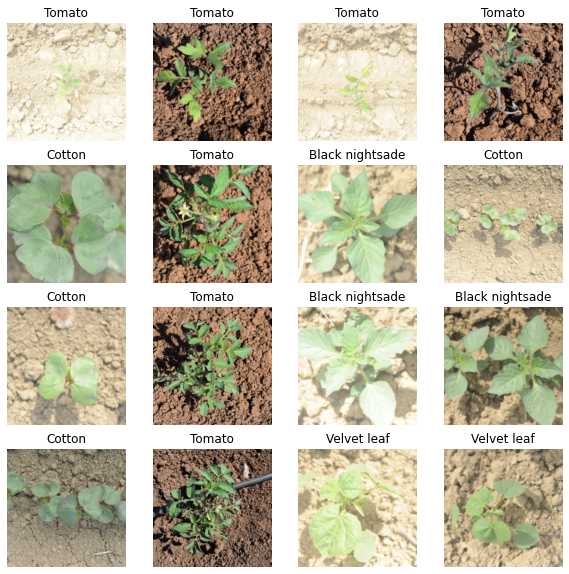

In [21]:
imshow(dataloaders, class_names)

#### Setting CUDA configuration if available

In [22]:
# Using CUDA if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


#### Training / Fine-Tuning Models
When using transfer learning, there are several strategies for reusing the weights or the knowledge learned on another task. Here 2 strategies are shown and compared:
1. **Feature Extraction**: The weights of the pre-trained architecture are not updated (the layers are frozen). This way, the architecture is used as a feature extractor while the last layer or classifier is trained to make sense of these features in the new problem.
2. **Fine-Tuning**: The weights of the pre-trained architecture are updated. The number of layers that are trained depends on the specific problem addressed and many times there is not a predefined best option.


In [23]:
# Loading and Training MobileNetV2 architectures
print("Training MobileNetV2 with Fine-Tuning strategy")
print("="*50)
v2_model_ft = get_mobilenet_architecture(version="2",
                                         pretrained=True,
                                         as_feature_extractor=False)
v2_model_ft, v2ft_val_acc_history = train_model(v2_model_ft,
                                                num_epochs=NUM_EPOCHS)

print("\nTraining MobileNetV2 with Feature Extractor strategy")
print("="*50)
v2_model_fe = get_mobilenet_architecture(version="2",
                                         pretrained=True,
                                         as_feature_extractor=True)
v2_model_fe, v2fe_val_acc_history = train_model(v2_model_fe,
                                                num_epochs=NUM_EPOCHS)

Training MobileNetV2 with Fine-Tuning strategy
Epoch 0/9
----------
train Loss: 0.9513 Acc: 0.6294 ||| val Loss: 0.4744 Acc: 0.8049
Epoch 1/9
----------
train Loss: 0.3005 Acc: 0.9373 ||| val Loss: 0.2577 Acc: 0.9106
Epoch 2/9
----------
train Loss: 0.1062 Acc: 0.9864 ||| val Loss: 0.2153 Acc: 0.9593
Epoch 3/9
----------
train Loss: 0.0660 Acc: 0.9891 ||| val Loss: 0.2538 Acc: 0.9106
Epoch 4/9
----------
train Loss: 0.0485 Acc: 0.9918 ||| val Loss: 0.2472 Acc: 0.9024
Epoch 5/9
----------
train Loss: 0.0355 Acc: 0.9946 ||| val Loss: 0.2831 Acc: 0.8780
Epoch 6/9
----------
train Loss: 0.0358 Acc: 0.9946 ||| val Loss: 0.1435 Acc: 0.9593
Epoch 7/9
----------
train Loss: 0.0268 Acc: 0.9946 ||| val Loss: 0.2367 Acc: 0.8943
Epoch 8/9
----------
train Loss: 0.0221 Acc: 0.9973 ||| val Loss: 0.2226 Acc: 0.9268
Epoch 9/9
----------
train Loss: 0.0233 Acc: 0.9973 ||| val Loss: 0.1761 Acc: 0.9350

Training complete in 11m 37s
Best val Acc: 0.959350


Training MobileNetV2 with Feature Extractor stra

In [24]:
# Loading and Training MobileNetV3 (Large) architectures
print("Training MobileNetV3 with Fine-Tuning strategy")
print("="*50)
v3_model_ft = get_mobilenet_architecture(version="3",
                                         pretrained=True,
                                         as_feature_extractor=False)
v3_model_ft, v3ft_val_acc_history = train_model(v3_model_ft,
                                                num_epochs=NUM_EPOCHS)

print("\nTraining MobileNetV3 with Feature Extractor strategy")
print("="*50)
v3_model_fe = get_mobilenet_architecture(version="3",
                                         pretrained=True,
                                         as_feature_extractor=True)
v3_model_fe, v3fe_val_acc_history = train_model(v3_model_fe,
                                                num_epochs=NUM_EPOCHS)

Training MobileNetV3 with Fine-Tuning strategy


Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /home/beast/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100.0%


Epoch 0/9
----------
train Loss: 1.1304 Acc: 0.5640 ||| val Loss: 1.0918 Acc: 0.6341
Epoch 1/9
----------
train Loss: 0.5719 Acc: 0.8937 ||| val Loss: 0.8102 Acc: 0.8374
Epoch 2/9
----------
train Loss: 0.3663 Acc: 0.9292 ||| val Loss: 0.5711 Acc: 0.9268
Epoch 3/9
----------
train Loss: 0.2150 Acc: 0.9755 ||| val Loss: 0.4145 Acc: 0.9187
Epoch 4/9
----------
train Loss: 0.1814 Acc: 0.9646 ||| val Loss: 0.3121 Acc: 0.9593
Epoch 5/9
----------
train Loss: 0.1345 Acc: 0.9728 ||| val Loss: 0.2564 Acc: 0.9512
Epoch 6/9
----------
train Loss: 0.0904 Acc: 0.9946 ||| val Loss: 0.1858 Acc: 0.9675
Epoch 7/9
----------
train Loss: 0.0709 Acc: 0.9864 ||| val Loss: 0.1637 Acc: 0.9756
Epoch 8/9
----------
train Loss: 0.0761 Acc: 0.9918 ||| val Loss: 0.1859 Acc: 0.9675
Epoch 9/9
----------
train Loss: 0.0779 Acc: 0.9946 ||| val Loss: 0.1929 Acc: 0.9431

Training complete in 11m 31s
Best val Acc: 0.975610


Training MobileNetV3 with Feature Extractor strategy
Epoch 0/9
----------
train Loss: 1.2400 Ac

#### Plotting Performances

In [27]:
# Preparing performances for being plotted
performances = [("MobileNetV2-Fine Tuning", v2ft_val_acc_history),
                ("MobileNetV2-Feature Extractor", v2fe_val_acc_history), 
                ("MobileNetV3-Fine Tuning", v3ft_val_acc_history), 
                ("MobileNetV3-Feature Extractor", v3fe_val_acc_history)]

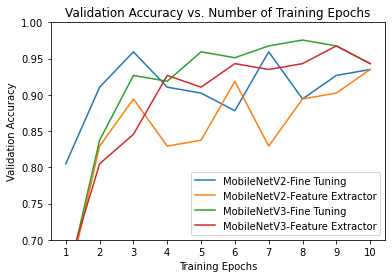

In [28]:
plot_performances(performances)

## Possible Extensions
1. Use a different pre-trained network (for instance, mobilenet_v3_small).
2. Try a different training approach where pre-trained weights are not loaded.
3. Try different learning rates (0.001 in this notebook) or even other optimization algorithms (e.g.: Adam) (SGD in this notebook).
4. Try different epochs and batch sizes.

## Bibliography
Bengio, Y., 2012. Deep Learning of Representations for Unsupervised and Transfer Learning. In: Journal of Machine Learning Research; 17–37.

Wang, G., Sun, Y., Wang, J., (2017). Automatic Image-Based Plant Disease Severity Estimation Using Deep Learning. Computational Intelligence and Neuroscience; 2017:8.

Mehdipour-Ghazi, M., Yanikoglu, B.A., & Aptoula, E. (2017). Plant identification using deep neural networks via optimization of transfer learning parameters. Neurocomputing, 235, 228-235.

Suh, H.K., IJsselmuiden, J., Hofstee, J.W., van Henten, E.J., (2018). Transfer learning for the classification of sugar beet and volunteer potato under field conditions. Biosystems Engineering; 174:50–65.

Kounalakis T., Triantafyllidis G. A., Nalpantidis L., (2019). Deep learning-based visual recognition of rumex for robotic precision farming. Computers and Electronics in Agriculture.

Too, E.C., Yujian, L., Njuki, S., & Ying-chun, L. (2019). A comparative study of fine-tuning deep learning models for plant disease identification. Comput. Electron. Agric., 161, 272-279.

Espejo-Garcia, B., Mylonas, N., Athanasakos, L., & Fountas, S., (2020). Improving
Weeds Identification with a Repository of Agricultural Pre-trained Deep Neural
Networks. Computers and Electronics in Agriculture; 175 (August).

Sandler, M., Howard, A.G., Zhu, M., Zhmoginov, A., & Chen, L. (2018). MobileNetV2: Inverted Residuals and Linear Bottlenecks. 2018 IEEE/CVF Conference on Computer Vision and Pattern Recognition, 4510-4520.

Howard, A.G., Sandler, M., Chu, G., Chen, L., Chen, B., Tan, M., Wang, W., Zhu, Y., Pang, R., Vasudevan, V., Le, Q.V., & Adam, H. (2019). Searching for MobileNetV3. 2019 IEEE/CVF International Conference on Computer Vision (ICCV), 1314-1324.

https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

https://www.oreilly.com/library/view/programming-pytorch-for/9781492045342/ch04.html